# Time-series Forecasting

## Description
The data consists of 52,416 observations of energy consumption on a 10-minute window. Every observation is described by the following feature columns.

Your task is to **aggregate the observations on an interval of 30 minutes**. For this time interval, using the values of the **5 previous time intervals**, forecast the target value one step in the future. Choose which features you are going to use.

**You must train an LSTM network.**



Features:

* Datetime: Time window of ten minutes.
* Temperature: Weather Temperature.
* Humidity: Weather Humidity.
* WindSpeed: Wind Speed.
* GeneralDiffuseFlows: “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
* DiffuseFlows

Target:

PowerConsumption

## Dataset links:
 * [DS1](https://drive.google.com/file/d/1k5Ee9kla-0s8iuEASsSY2u5hl6YstzlN/view?usp=sharing)
 * [DS2](https://drive.google.com/file/d/1--Kep6SOWuyQ2FTlBDdwWHj-65bOl1kc/view?usp=sharing)

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read the datasets

In [3]:
df1 = pd.read_csv('/content/drive/MyDrive/power_consumption_g1.csv')
df1

,Datetime,PowerConsumption
0,2017-10-04 02:20:00,26802.27571
1,2017-05-28 13:20:00,32898.09836
2,2017-03-15 06:00:00,22304.68085
3,2017-10-31 11:40:00,32316.49891
4,2017-04-20 02:50:00,23982.43272
...,...,...
52411,2017-05-27 13:30:00,35000.65574
52412,2017-10-29 20:10:00,39425.12035
52413,2017-02-05 16:10:00,28751.18644
52414,2017-04-11 17:20:00,32098.51453


In [4]:
df2 = pd.read_csv('/content/drive/MyDrive/power_consumption_g1_feat.csv')
df2

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
0,2017-03-01 16:40:00,21.33,55.91,0.080,387.400,427.300
1,2017-07-27 06:30:00,23.10,48.58,4.908,10.450,8.630
2,2017-10-11 19:00:00,23.10,59.82,0.084,0.446,0.322
3,2017-02-10 06:50:00,12.25,80.80,4.916,0.051,0.111
4,2017-03-06 16:00:00,15.62,59.38,0.075,533.400,579.900
...,...,...,...,...,...,...
52411,2017-05-14 02:20:00,23.58,43.10,0.075,0.110,0.122
52412,2017-11-17 19:20:00,17.30,76.50,0.075,0.040,0.148
52413,2017-03-21 12:10:00,17.90,50.28,0.081,837.000,296.700
52414,2017-07-28 05:10:00,25.23,61.32,4.907,0.091,0.119


## Merge the datasets (and pre-processing if needed)

In [6]:
merged_df = pd.merge(df1, df2, on='Datetime', how='inner')
merged_df

,Datetime,PowerConsumption,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
0,2017-10-04 02:20:00,26802.27571,24.95,36.88,4.920,0.099,0.130
1,2017-05-28 13:20:00,32898.09836,23.61,61.96,0.073,455.400,316.000
2,2017-03-15 06:00:00,22304.68085,9.36,90.00,0.087,0.026,0.108
3,2017-10-31 11:40:00,32316.49891,20.40,69.85,0.070,71.000,63.540
4,2017-04-20 02:50:00,23982.43272,15.81,86.90,0.069,0.018,0.119
...,...,...,...,...,...,...,...
52411,2017-05-27 13:30:00,35000.65574,21.72,71.60,4.917,678.500,264.800
52412,2017-10-29 20:10:00,39425.12035,18.18,79.20,4.923,0.048,0.085
52413,2017-02-05 16:10:00,28751.18644,11.61,37.40,0.085,392.300,35.680
52414,2017-04-11 17:20:00,32098.51453,16.03,84.00,0.075,290.600,274.600


In [7]:
merged_df['Datetime'] = pd.to_datetime(merged_df['Datetime'])

In [10]:
merged_df = merged_df.sort_values(by='Datetime')

In [11]:
merged_df = merged_df.set_index('Datetime')

In [12]:
merged_df

,PowerConsumption,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
Datetime,,,,,,
2017-01-01 00:00:00,34055.69620,6.559,73.8,0.083,0.051,0.119
2017-01-01 00:10:00,29814.68354,6.414,74.5,0.083,0.070,0.085
2017-01-01 00:20:00,29128.10127,6.313,74.5,0.080,0.062,0.100
2017-01-01 00:30:00,28228.86076,6.121,75.0,0.083,0.091,0.096
2017-01-01 00:40:00,27335.69620,5.921,75.7,0.081,0.048,0.085
...,...,...,...,...,...,...
2017-12-30 23:10:00,31160.45627,7.010,72.4,0.080,NaN,0.096
2017-12-30 23:20:00,30430.41825,6.947,72.6,0.082,0.051,0.093
2017-12-30 23:30:00,29590.87452,6.900,72.8,0.086,0.084,0.074


## Group the datasets into time intervals of 30 mintues

In [13]:
merged_df_resampled = merged_df.resample('30T').mean()

In [14]:
merged_df_resampled

,PowerConsumption,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
Datetime,,,,,,
2017-01-01 00:00:00,30999.493670,6.428667,74.266667,0.082000,0.061000,0.101333
2017-01-01 00:30:00,27396.455697,6.021000,75.866667,0.081667,0.066000,0.096333
2017-01-01 01:00:00,25407.594937,5.605000,77.900000,0.082000,0.056333,0.110000
2017-01-01 01:30:00,23906.835443,5.492667,77.166667,0.082000,0.057333,0.115000
2017-01-01 02:00:00,22474.936707,5.000667,78.766667,0.082667,0.065000,0.127333
...,...,...,...,...,...,...
2017-12-30 21:30:00,34786.311787,7.913333,70.343333,0.081667,0.069333,0.087667
2017-12-30 22:00:00,34660.583017,7.793333,69.563333,0.081000,0.062333,0.108667
2017-12-30 22:30:00,33326.235743,7.403333,71.066667,0.082667,0.055000,0.107667


In [15]:
merged_df_resampled.isnull().sum()

PowerConsumption       0
Temperature            8
Humidity               0
WindSpeed              9
GeneralDiffuseFlows    0
DiffuseFlows           0
dtype: int64

In [16]:
merged_df_resampled = merged_df_resampled.ffill()

In [17]:
merged_df_resampled.isnull().sum()

PowerConsumption       0
Temperature            0
Humidity               0
WindSpeed              0
GeneralDiffuseFlows    0
DiffuseFlows           0
dtype: int64

In [18]:
merged_df_resampled = merged_df_resampled.reset_index()

In [19]:
merged_df_resampled

,Datetime,PowerConsumption,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows
0,2017-01-01 00:00:00,30999.493670,6.428667,74.266667,0.082000,0.061000,0.101333
1,2017-01-01 00:30:00,27396.455697,6.021000,75.866667,0.081667,0.066000,0.096333
2,2017-01-01 01:00:00,25407.594937,5.605000,77.900000,0.082000,0.056333,0.110000
3,2017-01-01 01:30:00,23906.835443,5.492667,77.166667,0.082000,0.057333,0.115000
4,2017-01-01 02:00:00,22474.936707,5.000667,78.766667,0.082667,0.065000,0.127333
...,...,...,...,...,...,...,...
17467,2017-12-30 21:30:00,34786.311787,7.913333,70.343333,0.081667,0.069333,0.087667
17468,2017-12-30 22:00:00,34660.583017,7.793333,69.563333,0.081000,0.062333,0.108667
17469,2017-12-30 22:30:00,33326.235743,7.403333,71.066667,0.082667,0.055000,0.107667
17470,2017-12-30 23:00:00,31249.683140,7.009000,72.500000,0.080667,0.055000,0.094000


## Create lags

In [20]:
num_lags = 5

In [21]:
for i in range(1, num_lags + 1):
    merged_df_resampled[f'PowerConsumption_Lag_{i}'] = merged_df_resampled['PowerConsumption'].shift(i)

In [22]:
for column in ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows']:
    for i in range(1, num_lags + 1):
        merged_df_resampled[f'{column}_Lag_{i}'] = merged_df_resampled[column].shift(i)

In [23]:
merged_df_resampled = merged_df_resampled.dropna()

In [24]:
merged_df_resampled

,Datetime,PowerConsumption,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Lag_1,PowerConsumption_Lag_2,PowerConsumption_Lag_3,...,GeneralDiffuseFlows_Lag_1,GeneralDiffuseFlows_Lag_2,GeneralDiffuseFlows_Lag_3,GeneralDiffuseFlows_Lag_4,GeneralDiffuseFlows_Lag_5,DiffuseFlows_Lag_1,DiffuseFlows_Lag_2,DiffuseFlows_Lag_3,DiffuseFlows_Lag_4,DiffuseFlows_Lag_5
5,2017-01-01 02:30:00,21691.139240,5.108000,79.100000,0.082000,0.061000,0.131000,22474.936707,23906.835443,25407.594937,...,0.065000,0.057333,0.056333,0.066000,0.061000,0.127333,0.115000,0.110000,0.096333,0.101333
6,2017-01-01 03:00:00,20992.405063,5.097000,77.600000,0.082667,0.059667,0.130000,21691.139240,22474.936707,23906.835443,...,0.061000,0.065000,0.057333,0.056333,0.066000,0.131000,0.127333,0.115000,0.110000,0.096333
7,2017-01-01 03:30:00,20629.873417,4.911667,76.566667,0.083000,0.060000,0.152000,20992.405063,21691.139240,22474.936707,...,0.059667,0.061000,0.065000,0.057333,0.056333,0.130000,0.131000,0.127333,0.115000,0.110000
8,2017-01-01 04:00:00,20512.405063,4.952333,74.733333,0.083667,0.058667,0.117333,20629.873417,20992.405063,21691.139240,...,0.060000,0.059667,0.061000,0.065000,0.057333,0.152000,0.130000,0.131000,0.127333,0.115000
9,2017-01-01 04:30:00,20439.493670,5.243000,73.366667,0.081000,0.057333,0.128333,20512.405063,20629.873417,20992.405063,...,0.058667,0.060000,0.059667,0.061000,0.065000,0.117333,0.152000,0.130000,0.131000,0.127333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17467,2017-12-30 21:30:00,34786.311787,7.913333,70.343333,0.081667,0.069333,0.087667,35930.038023,36846.641317,37171.102660,...,0.077000,0.066000,0.039333,0.051333,0.052667,0.109000,0.090000,0.120000,0.095333,0.108667
17468,2017-12-30 22:00:00,34660.583017,7.793333,69.563333,0.081000,0.062333,0.108667,34786.311787,35930.038023,36846.641317,...,0.069333,0.077000,0.066000,0.039333,0.051333,0.087667,0.109000,0.090000,0.120000,0.095333
17469,2017-12-30 22:30:00,33326.235743,7.403333,71.066667,0.082667,0.055000,0.107667,34660.583017,34786.311787,35930.038023,...,0.062333,0.069333,0.077000,0.066000,0.039333,0.108667,0.087667,0.109000,0.090000,0.120000
17470,2017-12-30 23:00:00,31249.683140,7.009000,72.500000,0.080667,0.055000,0.094000,33326.235743,34660.583017,34786.311787,...,0.055000,0.062333,0.069333,0.077000,0.066000,0.107667,0.108667,0.087667,0.109000,0.090000


# Split the dataset into 80% training and 20% testing datasets

In [26]:
X = merged_df_resampled.drop(columns=['PowerConsumption'])
y = merged_df_resampled['PowerConsumption']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (13973, 36)
y_train shape: (13973,)
X_test shape: (3494, 36)
y_test shape: (3494,)


## Create the model, pre-process the data and make it suitable for training

In [33]:
X_train = X_train.drop(columns=['Datetime'])
X_test = X_test.drop(columns=['Datetime'])

In [34]:
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

In [35]:
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train_np)
X_test_scaled = scaler_X.transform(X_test_np)

In [36]:
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train_np.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test_np.reshape(-1, 1))

In [37]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [38]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                17200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 17251 (67.39 KB)
Trainable params: 17251 (67.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train the model, use 20% of the training dataset for validation
Train with 10 epochs (due to time limit)

In [40]:
epochs = 10

In [48]:
history = model.fit(
    X_train_reshaped, y_train_scaled,
    epochs=epochs,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
350/350 [==============================] - 2s 5ms/step - loss: 8.2292e-04 - val_loss: 8.7083e-04
Epoch 2/10
350/350 [==============================] - 1s 3ms/step - loss: 8.3172e-04 - val_loss: 0.0010
Epoch 3/10
350/350 [==============================] - 1s 3ms/step - loss: 7.9242e-04 - val_loss: 8.2099e-04
Epoch 4/10
350/350 [==============================] - 2s 5ms/step - loss: 7.4916e-04 - val_loss: 7.7447e-04
Epoch 5/10
350/350 [==============================] - 2s 5ms/step - loss: 7.0875e-04 - val_loss: 0.0010
Epoch 6/10
350/350 [==============================] - 1s 3ms/step - loss: 7.4077e-04 - val_loss: 7.9446e-04
Epoch 7/10
350/350 [==============================] - 1s 3ms/step - loss: 6.8679e-04 - val_loss: 7.6527e-04
Epoch 8/10
350/350 [==============================] - 1s 3ms/step - loss: 6.4359e-04 - val_loss: 7.2285e-04
Epoch 9/10
350/350 [==============================] - 1s 3ms/step - loss: 6.3978e-04 - val_loss: 6.9424e-04
Epoch 10/10
350/350 [===============

In [49]:
test_loss = model.evaluate(X_test_reshaped, y_test_scaled)
print(f'Test Loss: {test_loss}')

110/110 [==============================] - 0s 2ms/step - loss: 7.0024e-04
Test Loss: 0.0007002413622103631


## Plot the loss function on the training and validation dataset

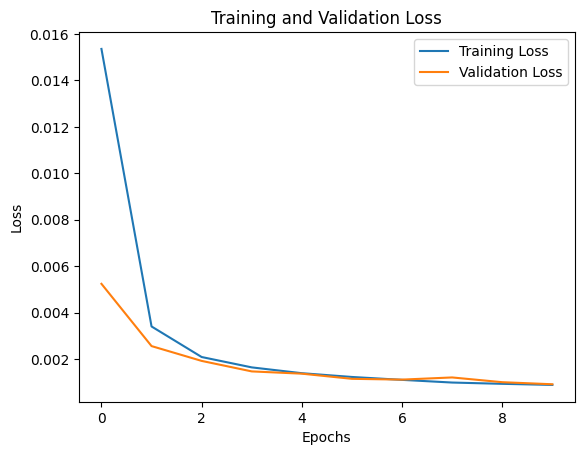

In [47]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Calculate the adequate metrics

In [51]:
y_pred_scaled = model.predict(X_test_reshaped)

110/110 [==============================] - 1s 2ms/step


In [52]:
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

## Visualize the targets against the predictions

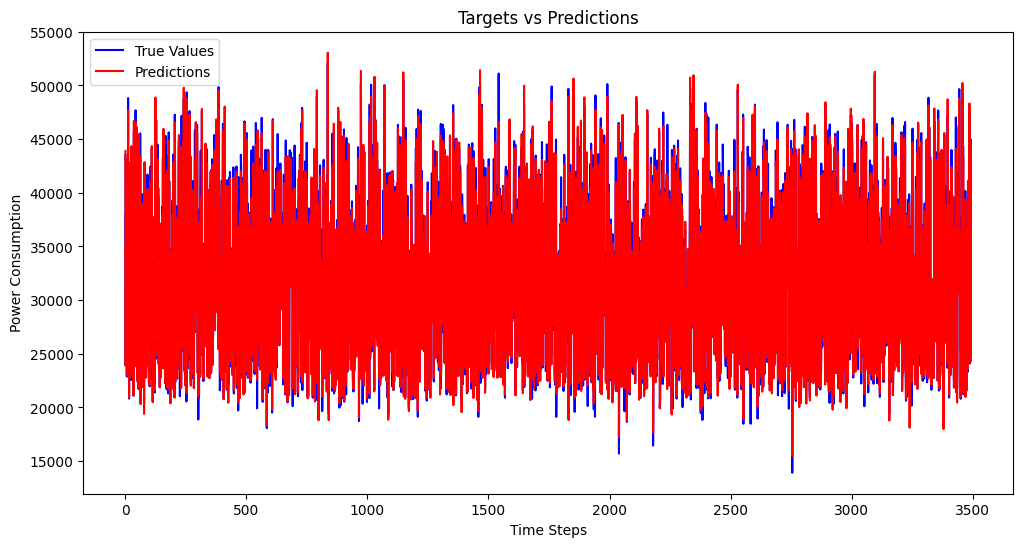

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='True Values', color='blue')
plt.plot(y_pred, label='Predictions', color='red')
plt.title('Targets vs Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()